In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_Adam_relu.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_Adam_relu.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
batch_size = 64
opt_rms = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True) 
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,\
                    verbose=1,validation_data=(x_val,y_val),callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp])

Epoch 1/200
625/625 [==============================] - 17s 27ms/step - loss: 2.0322 - acc: 0.3962 - val_loss: 1.8557 - val_acc: 0.4580
Epoch 2/200
625/625 [==============================] - 15s 24ms/step - loss: 1.6920 - acc: 0.4880 - val_loss: 1.4128 - val_acc: 0.5340
Epoch 3/200
625/625 [==============================] - 15s 24ms/step - loss: 1.5892 - acc: 0.5156 - val_loss: 2.0898 - val_acc: 0.5261
Epoch 4/200
625/625 [==============================] - 15s 24ms/step - loss: 1.4683 - acc: 0.5612 - val_loss: 1.1108 - val_acc: 0.6570
Epoch 5/200
625/625 [==============================] - 15s 23ms/step - loss: 1.3475 - acc: 0.6024 - val_loss: 1.0454 - val_acc: 0.6681
Epoch 6/200
625/625 [==============================] - 15s 24ms/step - loss: 1.3120 - acc: 0.6129 - val_loss: 1.8255 - val_acc: 0.6281
Epoch 7/200
625/625 [==============================] - 15s 24ms/step - loss: 1.3798 - acc: 0.6056 - val_loss: 1.0992 - val_acc: 0.6738
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 15s 23ms/step - loss: 0.5624 - acc: 0.8395 - val_loss: 0.5518 - val_acc: 0.8535
Epoch 62/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5692 - acc: 0.8386 - val_loss: 0.5578 - val_acc: 0.8532
Epoch 63/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5684 - acc: 0.8382 - val_loss: 0.5635 - val_acc: 0.8484
Epoch 64/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5644 - acc: 0.8376 - val_loss: 0.5337 - val_acc: 0.8573
Epoch 65/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5643 - acc: 0.8406 - val_loss: 0.5780 - val_acc: 0.8470
Epoch 66/200
625/625 [==============================] - 15s 23ms/step - loss: 0.5593 - acc: 0.8421 - val_loss: 0.5944 - val_acc: 0.8421
Epoch 67/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5623 - acc: 0.8406 - val_loss: 0.5641 - val_acc: 0.8519
Epoch 68/200
625/625 [==============================] - 15s 2

625/625 [==============================] - 15s 24ms/step - loss: 0.4198 - acc: 0.8844 - val_loss: 0.4753 - val_acc: 0.8763
Epoch 122/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4165 - acc: 0.8836 - val_loss: 0.4792 - val_acc: 0.8754
Epoch 123/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4213 - acc: 0.8844 - val_loss: 0.4668 - val_acc: 0.8782
Epoch 124/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4198 - acc: 0.8828 - val_loss: 0.4804 - val_acc: 0.8781
Epoch 125/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4194 - acc: 0.8839 - val_loss: 0.4642 - val_acc: 0.8802
Epoch 126/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4216 - acc: 0.8836 - val_loss: 0.4627 - val_acc: 0.8805
Epoch 127/200
625/625 [==============================] - 15s 23ms/step - loss: 0.4205 - acc: 0.8819 - val_loss: 0.4489 - val_acc: 0.8852
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3903 - acc: 0.8908 - val_loss: 0.4705 - val_acc: 0.8801
Epoch 182/200
625/625 [==============================] - 14s 23ms/step - loss: 0.3929 - acc: 0.8910 - val_loss: 0.4453 - val_acc: 0.8847
Epoch 183/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3902 - acc: 0.8896 - val_loss: 0.4391 - val_acc: 0.8879
Epoch 184/200
625/625 [==============================] - 15s 23ms/step - loss: 0.3921 - acc: 0.8925 - val_loss: 0.4469 - val_acc: 0.8863
Epoch 185/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3906 - acc: 0.8910 - val_loss: 0.4507 - val_acc: 0.8865
Epoch 186/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3895 - acc: 0.8915 - val_loss: 0.4669 - val_acc: 0.8799
Epoch 187/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3873 - acc: 0.8927 - val_loss: 0.4732 - val_acc: 0.8823
Epoch 188/200
625/625 [==================

In [17]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 1s 147us/step
0.48076058366298674
0.8746


In [18]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(200)

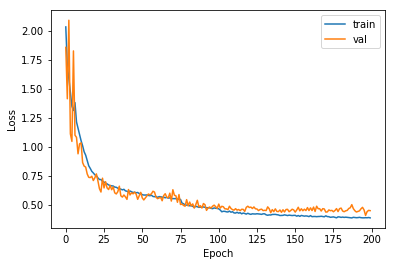

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

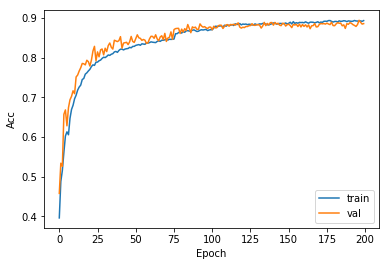

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [21]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[4.5950065e-07 6.0940142e-06 1.9824956e-04 9.9098092e-01 1.0527529e-04
  1.9824379e-03 6.7217858e-03 2.9344098e-06 1.5282401e-06 3.4886332e-07]]
3


In [22]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89      1000
     class 1       0.94      0.94      0.94      1000
     class 2       0.89      0.81      0.85      1000
     class 3       0.84      0.69      0.76      1000
     class 4       0.87      0.86      0.86      1000
     class 5       0.85      0.79      0.82      1000
     class 6       0.80      0.97      0.88      1000
     class 7       0.91      0.92      0.91      1000
     class 8       0.93      0.92      0.93      1000
     class 9       0.86      0.95      0.90      1000

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [23]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[892  14  12   8   9   0   3   5  28  29]
 [  3 938   0   0   0   0   2   0   3  54]
 [ 35   3 811  15  28  20  59  14   4  11]
 [ 12   3  32 694  33  96  78  19  13  20]
 [  8   1  17  17 856   8  62  24   6   1]
 [  8   3  20  80  26 787  32  32   1  11]
 [  2   2   8   7   4   1 972   1   1   2]
 [ 13   0   8   7  26  15   3 920   3   5]
 [ 28  13   2   2   0   0   7   0 922  26]
 [  8  22   2   1   1   1   3   0   8 954]]
0.8746
0.12539999999999996


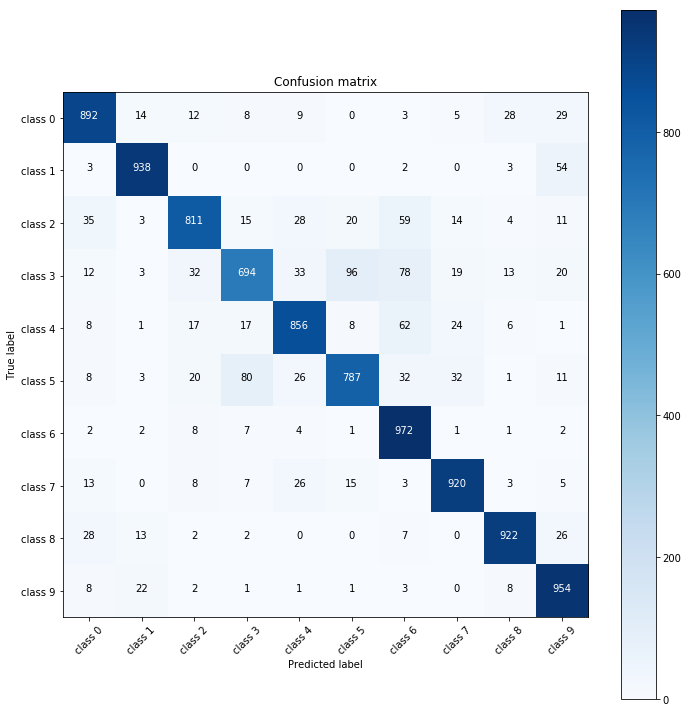

In [24]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')